#  Final Project: Asset Performance During Different Market Fear Levels
This project by **Yutong Wu** explores three multi-asset portfolio strategies informed by market sentiment (VIX index). I examine how asset allocation based on fear levels can improve risk-adjusted returns.

**Strategies:**
- **Fear-Level Strategy**: Rotate assets based on Low / Medium / High VIX.
- **Equal-Weight Strategy**: Hold all assets with equal weights.
- **Risk-On/Off Strategy**: Switch between risk-on (SP500 + BTC) and risk-off (Gold + TLT) regimes.


# Title: Asset Performance During Different Market Fear Levels

This project investigates how asset classes like SP500, Gold, Oil, TLT, and Bitcoin perform under different market fear regimes using the VIX index as a proxy. The main research questions:

- How do returns and risks of assets change with VIX levels?
- Can we build switching strategies based on fear levels?
- What patterns exist in asset correlations across regimes?


## Step 1: Download and Clean Raw Data
I use `yfinance` to download historical data for SP500, VIX, Gold, TLT, Oil, and Bitcoin, and save to CSV.

In [1]:
import yfinance as yf
import pandas as pd

tickers = {
    "^GSPC": "SP500",
    "^VIX": "VIX",
    "GC=F": "Gold",
    "TLT": "TLT",
    "CL=F": "Oil",
    "BTC-USD": "Bitcoin"
}

start_date = "2008-01-01"
end_date = "2024-04-30"

data = {}
for ticker, name in tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        data[name] = df['Close']
    else:
        print(f"Warning: {name} ({ticker}) has no data and will be skipped.")

# Use concat instead of DataFrame to merge
combined_df = pd.concat(data.values(), axis=1)
combined_df.columns = data.keys()  # Set column names

# Preview the first few rows
print(combined_df.head())

# Save to CSV
combined_df.to_csv("multi_asset_market_data.csv")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  SP500        VIX        Gold        TLT        Oil  Bitcoin
Date                                                                         
2008-01-02  1447.160034  23.170000  857.000000  56.674694  99.620003      NaN
2008-01-03  1447.160034  22.490000  866.400024  56.596642  99.180000      NaN
2008-01-04  1411.630005  23.940001  863.099976  56.608639  97.910004      NaN
2008-01-07  1416.180054  23.790001  859.599976  56.854877  95.089996      NaN
2008-01-08  1390.189941  25.430000  878.000000  56.788803  96.330002      NaN


In [2]:
# Load data
import pandas as pd

df = pd.read_csv('multi_asset_market_data.csv', index_col=0, parse_dates=True)

# Process in phases
# Step 1: From 2008 to 2013, require no NaNs in SP500, VIX, Gold, TLT, Oil
df_early = df.loc[:'2014-09-16', ['SP500', 'VIX', 'Gold', 'TLT', 'Oil']]
df_early = df_early.dropna()

# Step 2: From 2014 onward, require all assets including Bitcoin to be present
df_late = df.loc['2014-09-17':, ['SP500', 'VIX', 'Gold', 'TLT', 'Oil', 'Bitcoin']]
df_late = df_late.dropna()

# Step 3: Merge both periods
combined_cleaned = pd.concat([df_early, df_late], axis=0)

# Save cleaned data
combined_cleaned.to_csv('multi_asset_market_data_cleaned.csv')

# Preview results
print(combined_cleaned.head())
print(combined_cleaned.tail())


                  SP500        VIX        Gold        TLT        Oil  Bitcoin
Date                                                                         
2008-01-02  1447.160034  23.170000  857.000000  56.674694  99.620003      NaN
2008-01-03  1447.160034  22.490000  866.400024  56.596642  99.180000      NaN
2008-01-04  1411.630005  23.940001  863.099976  56.608639  97.910004      NaN
2008-01-07  1416.180054  23.790001  859.599976  56.854877  95.089996      NaN
2008-01-08  1390.189941  25.430000  878.000000  56.788803  96.330002      NaN
                  SP500    VIX         Gold        TLT        Oil  \
Date                                                                
2024-04-23  5070.549805  15.69  2327.699951  85.149399  83.360001   
2024-04-24  5071.629883  15.97  2324.500000  84.546860  82.809998   
2024-04-25  5048.419922  15.37  2329.800049  83.953880  83.570000   
2024-04-26  5099.959961  15.03  2334.800049  84.393837  83.849998   
2024-04-29  5116.169922  14.67  2345.399

## Step 2: Load Cleaned Dataset
Load the preprocessed dataset `multi_asset_market_data_cleaned.csv`, and compute daily returns.

In [3]:
# Step 1: Load the cleaned dataset
import pandas as pd

combined_cleaned = pd.read_csv('multi_asset_market_data_cleaned.csv', index_col=0, parse_dates=True)

# Step 2: Define function to label fear levels based on VIX
def label_fear_level(vix):
    if vix < 20:
        return "Low"
    elif vix <= 30:
        return "Medium"
    else:
        return "High"

# Step 3: Apply function to create a new "Fear_Level" column
combined_cleaned['Fear_Level'] = combined_cleaned['VIX'].apply(label_fear_level)

# Step 4: Preview results after labeling
print(combined_cleaned[['VIX', 'Fear_Level']].head(10))


                  VIX Fear_Level
Date                            
2008-01-02  23.170000     Medium
2008-01-03  22.490000     Medium
2008-01-04  23.940001     Medium
2008-01-07  23.790001     Medium
2008-01-08  25.430000     Medium
2008-01-09  24.120001     Medium
2008-01-10  23.450001     Medium
2008-01-11  23.680000     Medium
2008-01-14  22.900000     Medium
2008-01-15  23.340000     Medium


In [4]:
# Calculate daily simple returns
returns = combined_cleaned[['SP500', 'Gold', 'TLT', 'Oil', 'Bitcoin']].pct_change()

# Drop the first row containing NaN
returns = returns.dropna()

# Ensure alignment between returns and fear labels
returns['Fear_Level'] = combined_cleaned['Fear_Level'].iloc[1:]


In [5]:
# Step 1: Select only asset return columns (exclude Fear_Level)
asset_cols = ['SP500', 'Gold', 'TLT', 'Oil', 'Bitcoin']
returns_only = returns[asset_cols]

# Step 2: Add back Fear_Level for grouping
returns_only['Fear_Level'] = returns['Fear_Level']

# Step 3: Group by Fear_Level
grouped = returns_only.groupby('Fear_Level')

# Step 4: Initialize result container
summary = {}

# Step 5: Compute metrics for each fear level
for level, group in grouped:
    mean_return = group[asset_cols].mean() * 252  # Annualized return
    vol = group[asset_cols].std() * (252 ** 0.5)   # Annualized volatility
    sharpe = mean_return / vol                     # Sharpe ratio
    
    summary[level] = pd.DataFrame({
        'Annualized Return': mean_return,
        'Annualized Volatility': vol,
        'Sharpe Ratio': sharpe
    })

# Step 6: Combine results from all fear levels
performance_summary = pd.concat(summary, axis=1)

# Step 7: View the result
performance_summary


High                                     \
        Annualized Return Annualized Volatility Sharpe Ratio   
SP500           -1.212499              0.478369    -2.534651   
Gold             0.177047              0.243409     0.727366   
TLT             -0.070687              0.294826    -0.239759   
Oil             -7.048227              4.569444    -1.542469   
Bitcoin         -1.243256              0.968071    -1.284261   

                      Low                                     \
        Annualized Return Annualized Volatility Sharpe Ratio   
SP500            0.326797              0.105895     3.086062   
Gold             0.017938              0.128315     0.139793   
TLT             -0.013157              0.129441    -0.101645   
Oil              0.173023              0.331675     0.521664   
Bitcoin          0.908502              0.646966     1.404250   

                   Medium                                     
        Annualized Return Annualized Volatility Sharpe Ratio  
SP500           -0.158355              0.206312    -0.767553  
Gold             0.218983              0.162629     1.346519  
TLT              0.096995              0.164547     0.589464  
Oil              0.024832              0.461763     0.053777  
Bitcoin          0.824802              0.751052     1.098197

##  Step 3: Visualize Basic Asset Statistics
I compute annualized returns, volatilities, or Sharpe ratios under different VIX fear regimes.

In [6]:
import plotly.express as px
import pandas as pd

# Reshape data for plotting
asset_cols = ['SP500', 'Gold', 'TLT', 'Oil', 'Bitcoin']
fear_levels = ['Low', 'Medium', 'High']

# Data for annualized return bar chart
annual_return_data = []
for fear in fear_levels:
    for asset in asset_cols:
        annual_return = performance_summary[fear].loc[asset, 'Annualized Return']
        annual_return_data.append({'Asset': asset, 'Fear_Level': fear, 'Annualized Return': annual_return})

annual_return_df = pd.DataFrame(annual_return_data)

# Data for annualized volatility bar chart
volatility_data = []
for fear in fear_levels:
    for asset in asset_cols:
        vol = performance_summary[fear].loc[asset, 'Annualized Volatility']
        volatility_data.append({'Asset': asset, 'Fear_Level': fear, 'Annualized Volatility': vol})

volatility_df = pd.DataFrame(volatility_data)

# Data for Sharpe ratio bar chart
sharpe_data = []
for fear in fear_levels:
    for asset in asset_cols:
        sharpe = performance_summary[fear].loc[asset, 'Sharpe Ratio']
        sharpe_data.append({'Asset': asset, 'Fear_Level': fear, 'Sharpe Ratio': sharpe})

sharpe_df = pd.DataFrame(sharpe_data)

# Plotting!

# Annualized return bar chart
fig_return = px.bar(annual_return_df, x='Asset', y='Annualized Return', color='Fear_Level', barmode='group',
                    title="Annualized Return by Fear Level")
fig_return.show()

# Annualized volatility bar chart
fig_vol = px.bar(volatility_df, x='Asset', y='Annualized Volatility', color='Fear_Level', barmode='group',
                 title="Annualized Volatility by Fear Level")
fig_vol.show()

# Sharpe ratio bar chart
fig_sharpe = px.bar(sharpe_df, x='Asset', y='Sharpe Ratio', color='Fear_Level', barmode='group',
                    title="Sharpe Ratio by Fear Level")
fig_sharpe.show()


In [7]:
import plotly.express as px
import pandas as pd

# Load the processed data (you should already have combined_cleaned)
# Uncomment if needed:
# combined_cleaned = pd.read_csv('multi_asset_market_data_cleaned.csv', index_col=0, parse_dates=True)

# Plot
fig_vix = px.line(
    combined_cleaned,
    x=combined_cleaned.index,
    y='VIX',
    color='Fear_Level',  # Color by fear level
    title='VIX Index Over Time with Fear Levels',
    labels={'VIX': 'VIX Index'}
)

fig_vix.update_traces(mode="lines+markers")  # Add markers on the lines
fig_vix.update_layout(
    xaxis_title="Date",
    yaxis_title="VIX Index",
    legend_title="Fear Level",
    hovermode="x unified"
)

fig_vix.show()


c:\Users\mini\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [8]:
import plotly.express as px
import pandas as pd

# Select only numerical assets
asset_cols = ['SP500', 'Gold', 'TLT', 'Oil', 'Bitcoin']

# Make sure returns data is prepared (uncomment if needed)
# returns = combined_cleaned[asset_cols].pct_change().dropna()
# returns['Fear_Level'] = combined_cleaned['Fear_Level'].iloc[1:]

# Pre-confirm return columns
returns_only = returns[asset_cols + ['Fear_Level']]

# Define a function to plot correlation heatmap by fear level
def plot_correlation_heatmap(fear_level):
    df = returns_only[returns_only['Fear_Level'] == fear_level][asset_cols]
    corr = df.corr()
    
    fig = px.imshow(
        corr,
        text_auto=True,
        color_continuous_scale='RdBu_r',
        zmin=-1, zmax=1,
        title=f'Asset Correlation Heatmap - {fear_level} Fear'
    )
    
    fig.update_layout(width=600, height=500)
    fig.show()

# Plot heatmap for each fear level (Low, Medium, High)
for fear in ['Low', 'Medium', 'High']:
    plot_correlation_heatmap(fear)


## Step 4: VIX Distribution by Fear Level
Violin plot shows the distribution of VIX under Low, Medium, and High fear regimes.

In [9]:
# Violin plot showing the distribution of VIX under different Fear Levels

import plotly.express as px

fig = px.violin(
    combined_cleaned,  
    y='VIX',
    color='Fear_Level',
    box=True,
    points='all',
    title="VIX Distribution by Fear Level",
    labels={'VIX': 'VIX Index', 'Fear_Level': 'Fear Level'}
)
fig.show()


##  Step 5: Drawdown Analysis
This plot illustrates peak-to-trough losses for each asset, useful for understanding downside risk.

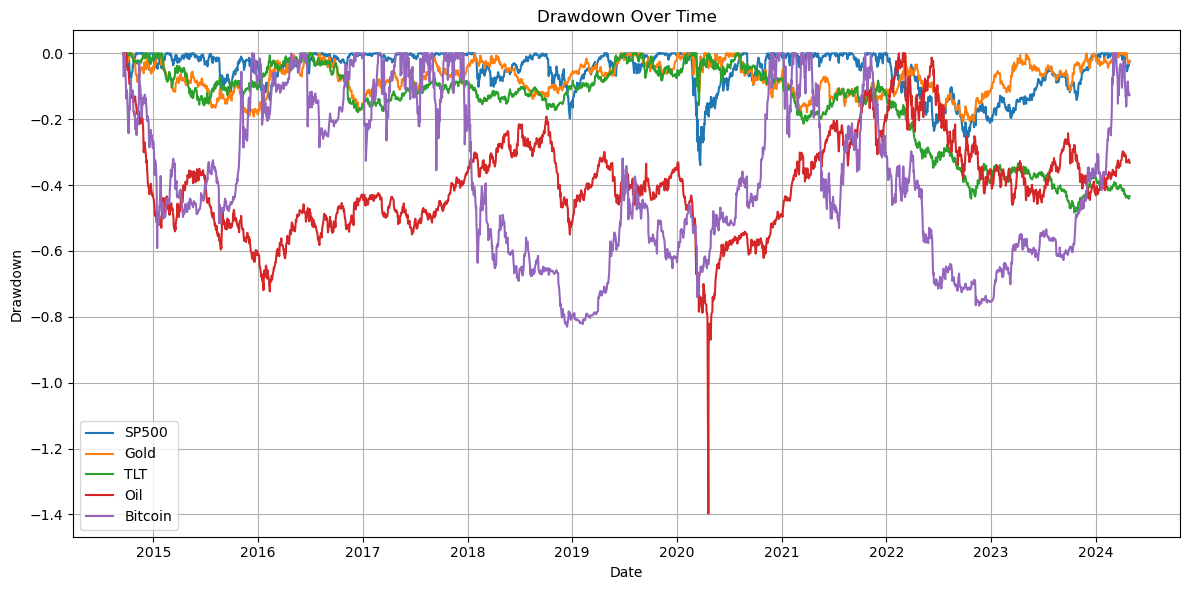

In [10]:
import matplotlib.pyplot as plt

# Specify assets to analyze (e.g., selected_assets = ['SP500', 'Gold'])
selected_assets = asset_cols

# Calculate cumulative returns (based on returns variable)
cumulative_returns = (1 + returns[selected_assets]).cumprod()

# Calculate historical maximum values
running_max = cumulative_returns.cummax()

# Calculate drawdowns (as percentage)
drawdowns = (cumulative_returns - running_max) / running_max

# Plot
plt.figure(figsize=(12, 6))
for asset in selected_assets:
    plt.plot(drawdowns.index, drawdowns[asset], label=asset)

plt.title("Drawdown Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 6: Strategy Cumulative Returns
I compute and compare cumulative return curves for three strategies.

In [11]:
import plotly.express as px
import numpy as np

# Calculate cumulative returns
cumulative_returns = (1 + returns[asset_cols]).cumprod()

# Take logarithm of cumulative returns
log_cum_returns = np.log(cumulative_returns)

# Plot line chart of log cumulative returns
fig_cum_log = px.line(
    log_cum_returns,
    x=log_cum_returns.index,
    y=asset_cols,
    title="Log Cumulative Returns of Assets Over Time",
    labels={"value": "Log Cumulative Return", "index": "Date"},
)

fig_cum_log.update_layout(
    xaxis_title="Date",
    yaxis_title="Log Cumulative Return",
    hovermode="x unified"
)

fig_cum_log.show()


c:\Users\mini\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning:

invalid value encountered in log

c:\Users\mini\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



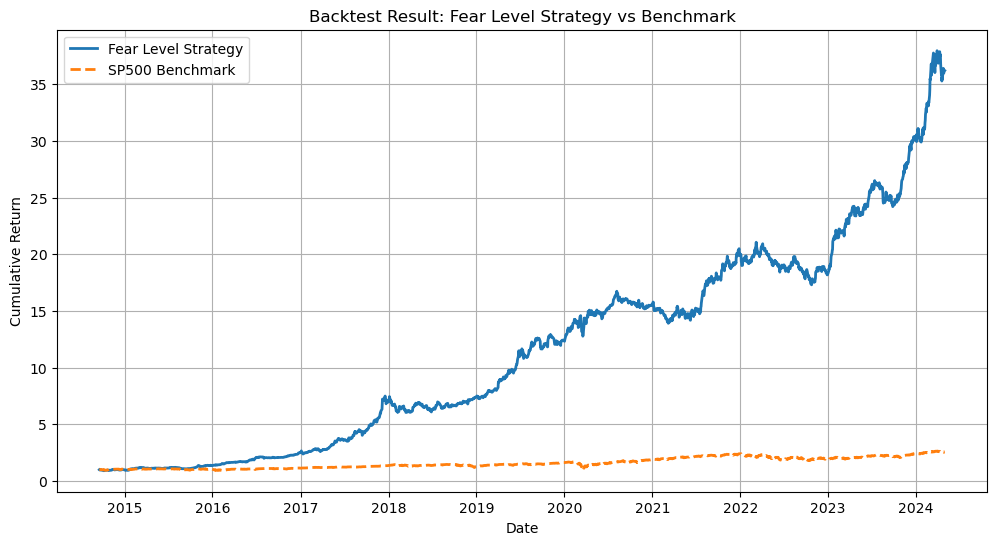

In [12]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read data
df = pd.read_csv('daily_returns_with_fear_level.csv', parse_dates=['Date'], index_col='Date')

# Set weights for each fear level
weights = {
    'Low': {'SP500': 0.7, 'Bitcoin': 0.3},
    'Medium': {'Gold': 0.5, 'TLT': 0.5},
    'High': {'Gold': 0.8, 'TLT': 0.2}
}

# Create an empty list to store portfolio returns for each day
portfolio_returns = []

# Iterate over each day
for date, row in df.iterrows():
    fear = row['Fear_Level']
    daily_return = 0.0
    if fear in weights:
        for asset, weight in weights[fear].items():
            daily_return += row[asset] * weight
    portfolio_returns.append(daily_return)

# Convert result to a Series
portfolio_returns = pd.Series(portfolio_returns, index=df.index)

# Compute cumulative returns of the strategy
strategy_cum_returns = (1 + portfolio_returns).cumprod()

# Compute cumulative returns of the benchmark (e.g., SP500)
benchmark_returns = df['SP500']
benchmark_cum_returns = (1 + benchmark_returns).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(strategy_cum_returns, label='Fear Level Strategy', linewidth=2)
plt.plot(benchmark_cum_returns, label='SP500 Benchmark', linewidth=2, linestyle='--')
plt.title('Backtest Result: Fear Level Strategy vs Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# --- Calculate Backtest Metrics ---

# 1. Annualized Return
days = (strategy_cum_returns.index[-1] - strategy_cum_returns.index[0]).days
annual_return_strategy = (strategy_cum_returns.iloc[-1]) ** (365.0 / days) - 1
annual_return_benchmark = (benchmark_cum_returns.iloc[-1]) ** (365.0 / days) - 1

# 2. Annualized Volatility
strategy_volatility = portfolio_returns.std() * np.sqrt(252)
benchmark_volatility = benchmark_returns.std() * np.sqrt(252)

# 3. Sharpe Ratio (Assume risk-free rate = 0)
sharpe_strategy = annual_return_strategy / strategy_volatility
sharpe_benchmark = annual_return_benchmark / benchmark_volatility

# 4. Maximum Drawdown
def calculate_max_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    return max_drawdown

max_drawdown_strategy = calculate_max_drawdown(strategy_cum_returns)
max_drawdown_benchmark = calculate_max_drawdown(benchmark_cum_returns)

# --- Print Metrics Table ---
import pandas as pd

metrics = pd.DataFrame({
    'Strategy': [annual_return_strategy, strategy_volatility, sharpe_strategy, max_drawdown_strategy],
    'Benchmark (SP500)': [annual_return_benchmark, benchmark_volatility, sharpe_benchmark, max_drawdown_benchmark]
}, index=['Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown'])

# Format and print
print("\n=== Backtest Performance Metrics ===")
print(metrics.applymap(lambda x: f"{x:.2%}" if isinstance(x, float) else x))



=== Backtest Performance Metrics ===
                      Strategy Benchmark (SP500)
Annualized Return       45.22%            10.25%
Annualized Volatility   19.32%            18.01%
Sharpe Ratio           234.12%            56.89%
Max Drawdown           -19.37%           -33.92%


C:\Users\mini\AppData\Local\Temp\ipykernel_39764\2632591829.py:36: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



## Step 7: Strategy Performance Metrics
Annualized return, volatility, and Sharpe ratio are calculated for each strategy.

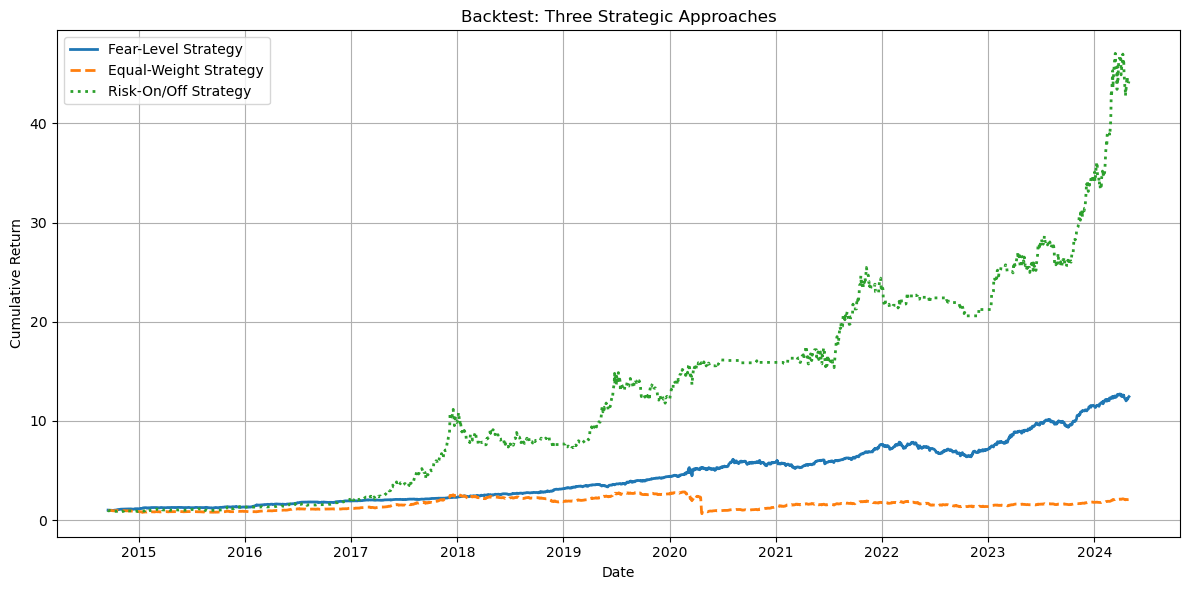

In [14]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Asset columns to be used
asset_cols = ['SP500', 'Gold', 'TLT', 'Oil', 'Bitcoin']

# Use the already loaded DataFrame: combined_cleaned
df = combined_cleaned.copy()

# Add Fear_Level classification (if not already done)
df['Fear_Level'] = df['VIX'].apply(label_fear_level)

# Compute daily returns
returns = df[asset_cols].pct_change().dropna()
returns['Fear_Level'] = df['Fear_Level'].shift(-1).loc[returns.index]  # Forward align

# Strategy 1: Fear-Level Strategy (allocate based on VIX level)
strategy_fear = np.where(
    returns['Fear_Level'] == 'Low', returns['SP500'],
    np.where(returns['Fear_Level'] == 'Medium', returns['Gold'], returns['TLT'])
)
port_fear = pd.Series(strategy_fear, index=returns.index)
cum_fear = (1 + port_fear).cumprod()

# Strategy 2: Equal-Weight Strategy (equal allocation to all assets)
port_eq = returns[asset_cols].mean(axis=1)
cum_eq = (1 + port_eq).cumprod()

# Strategy 3: Risk-On/Risk-Off Strategy
port_roro = np.where(
    returns['Fear_Level'] == 'Low',
    returns[['SP500', 'Bitcoin']].mean(axis=1),
    np.where(returns['Fear_Level'] == 'Medium', 0.0,
             returns[['Gold', 'TLT']].mean(axis=1))
)
port_roro = pd.Series(port_roro, index=returns.index)
cum_roro = (1 + port_roro).cumprod()

# Visualize cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cum_fear, label='Fear-Level Strategy', linewidth=2)
plt.plot(cum_eq, label='Equal-Weight Strategy', linewidth=2, linestyle='--')
plt.plot(cum_roro, label='Risk-On/Off Strategy', linewidth=2, linestyle=':')
plt.title('Backtest: Three Strategic Approaches')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
ann_factor = 252
n_days = len(returns)

def calc_metrics(portfolio_returns):
    cum_return = (1 + portfolio_returns).cumprod().iloc[-1] - 1
    ann_return = (1 + cum_return) ** (ann_factor / n_days) - 1
    ann_vol = portfolio_returns.std() * np.sqrt(ann_factor)
    sharpe = ann_return / ann_vol
    return cum_return, ann_return, ann_vol, sharpe

metrics = {
    "Fear-Level": calc_metrics(port_fear),
    "Equal-Weight": calc_metrics(port_eq),
    "Risk-On/Off": calc_metrics(port_roro)
}

summary = pd.DataFrame(metrics, index=[
    'Cumulative Return', 'Annualized Return', 'Volatility', 'Sharpe Ratio']
).T
summary.style.format({
    'Cumulative Return': '{:.2%}',
    'Annualized Return': '{:.2%}',
    'Volatility': '{:.2%}',
    'Sharpe Ratio': '{:.2f}'
})


,Cumulative Return,Annualized Return,Volatility,Sharpe Ratio
Fear-Level,1144.36%,30.08%,14.20%,2.12
Equal-Weight,106.44%,7.85%,28.95%,0.27
Risk-On/Off,4323.10%,48.48%,28.17%,1.72
